# TP1 : modèles de diffusion en 2D

### Définition des données

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset, random_split

# Générer des données 2D
def generate_2d_data(n_samples=1000, noise_level=0.1):
    angles = np.linspace(0, 2 * np.pi, n_samples)
    x = np.stack([np.cos(angles), np.sin(angles)], axis=1)  # Points du cercle
    x += np.random.normal(0, noise_level, x.shape)  # Ajouter du bruit
    return torch.tensor(x, dtype=torch.float32)

# Préparer le dataset
data = generate_2d_data(10000)
dataset = TensorDataset(data)

# Diviser les données en ensembles d'entraînement, de validation et de test
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### Définition du modèle de diffusion

In [19]:
# Modèle de Diffusion
class DiffusionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(DiffusionModel, self).__init__()
        # Définition des couches linéaires
        self.fc1 = nn.Linear(input_dim + 1, hidden_dim)
        # +1 pour le temps t
        self.fc2 = nn.Linear(hidden_dim, input_dim)

    def forward(self, x, t):
        # Ajout d'informations temporelles t
        t = t.unsqueeze(1) # Ajouter une dimension pour concaténer avec x
        x_t = torch.cat([x, t], dim=-1)
        h = torch.relu(self.fc1(x_t)) # Application de la fonction d'activation ReL
        return self.fc2(h)

# Fonction de perte
def diffusion_loss(x, x_noisy, noise_pred):
    return nn.MSELoss()(noise_pred, x_noisy - x)

### Entrainement du modèle de diffusion

In [23]:
# Initialiser le modèle et l'optimiseur
input_dim = 2  # Données en 2D
hidden_dim = 128
epochs = 200
T = 100  # Nombre de pas de temps

diffusion_model = DiffusionModel(input_dim=input_dim, hidden_dim=hidden_dim)
optimizer = optim.Adam(diffusion_model.parameters(), lr=1e-4)

# Ajouter un learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

# Fonction pour sauvegarder le modèle
def save_model(model, path):
    torch.save(model.state_dict(), path)

# Fonction pour charger le modèle
def load_model(model, path):
    model.load_state_dict(torch.load(path))

# Chemin pour sauvegarder le meilleur modèle
best_model_path = 'best_diffusion_model.pth'
best_val_loss = float('inf')

# Entraînement du modèle
for epoch in range(epochs):
    diffusion_model.train()
    train_loss = 0
    for batch in train_loader:
      x = batch[0]
      t = torch.randint(0, T, (x.size(0),)) # Temps aléatoire
      noise = torch.randn_like(x)
      x_noisy = x + noise * torch.sqrt(t.float() / T).unsqueeze(1) # Ajout de bruit

      optimizer.zero_grad() # Réinitialisation des gradients
      noise_pred = diffusion_model(x, t.float()) # Prédiction du bruit
      loss = diffusion_loss(x, x_noisy, noise_pred) # Calcul de la perte
      loss.backward() # Rétropropagation
      optimizer.step() # Mise à jour des poids

      train_loss += loss.item()

    train_loss /= len(train_loader)

    # Validation
    diffusion_model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
          x = batch[0]
          t = torch.randint(0, T, (x.size(0),)) # Temps aléatoire
          noise = torch.randn_like(x)
          x_noisy = x + noise * torch.sqrt(t.float() / T).unsqueeze(1) # Ajout de bruit

          optimizer.zero_grad() # Réinitialisation des gradients
          noise_pred = diffusion_model(x, t.float()) # Prédiction du bruit
          loss = diffusion_loss(x, x_noisy, noise_pred) # Calcul de la perte
          optimizer.step() # Mise à jour des poids

          val_loss += loss.item()

    val_loss /= len(val_loader)

    # Mettre à jour le learning rate scheduler
    scheduler.step()

    # Sauvegarder le meilleur modèle
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        save_model(diffusion_model, best_model_path)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

Epoch 0, Train Loss: 22.6331, Val Loss: 0.7769
Epoch 10, Train Loss: 0.4855, Val Loss: 0.5155
Epoch 20, Train Loss: 0.5071, Val Loss: 0.5147
Epoch 30, Train Loss: 0.5028, Val Loss: 0.4994
Epoch 40, Train Loss: 0.5105, Val Loss: 0.5232
Epoch 50, Train Loss: 0.4969, Val Loss: 0.4860
Epoch 60, Train Loss: 0.4967, Val Loss: 0.5089
Epoch 70, Train Loss: 0.4999, Val Loss: 0.4851
Epoch 80, Train Loss: 0.5019, Val Loss: 0.5109
Epoch 90, Train Loss: 0.4940, Val Loss: 0.4926
Epoch 100, Train Loss: 0.4978, Val Loss: 0.4943
Epoch 110, Train Loss: 0.4953, Val Loss: 0.4944
Epoch 120, Train Loss: 0.4976, Val Loss: 0.4978
Epoch 130, Train Loss: 0.5054, Val Loss: 0.4764
Epoch 140, Train Loss: 0.4985, Val Loss: 0.4994
Epoch 150, Train Loss: 0.4991, Val Loss: 0.5081
Epoch 160, Train Loss: 0.4896, Val Loss: 0.5047
Epoch 170, Train Loss: 0.4994, Val Loss: 0.4821
Epoch 180, Train Loss: 0.4991, Val Loss: 0.4807
Epoch 190, Train Loss: 0.4980, Val Loss: 0.4582
Epoch 200, Train Loss: 0.4917, Val Loss: 0.4908
Ep

### Evaluation du modèle, génération de données

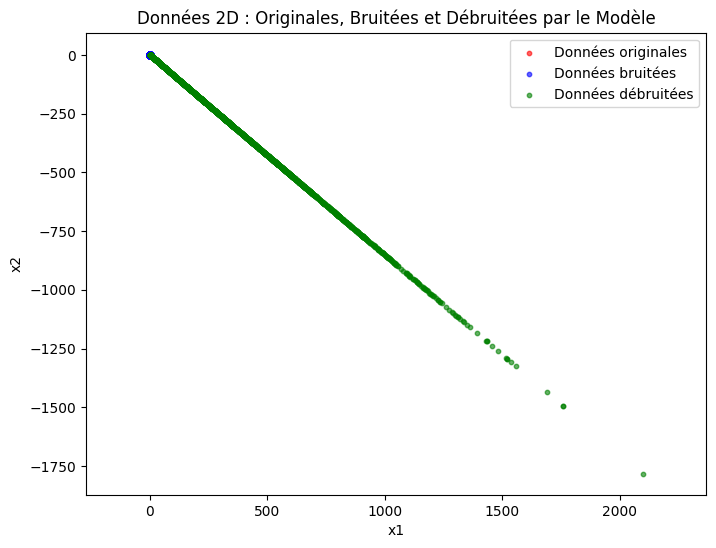

In [27]:
# Fonction pour débruiter les données en plusieurs étapes
def denoise_data_multi_step(model, x_noisy, T, steps):
    with torch.no_grad():
        x_denoised = x_noisy
        for step in range(steps):
            t = torch.full((x_denoised.size(0),), T - step, dtype=torch.float32)
            noise_pred = model(x_denoised, t)
            x_denoised = x_denoised + noise_pred
        return x_denoised

# Générer des données bruitées et débruitées par le modèle en plusieurs étapes
with torch.no_grad():
    t = torch.tensor([1.0] * data.size(0), dtype=torch.float32)  # Temps initial pour visualisation
    noise = torch.randn_like(data)
    x_noisy = data + noise * torch.sqrt(t).unsqueeze(1)
    steps = 100  # Nombre d'étapes de débruitage
    denoised_data = denoise_data_multi_step(diffusion_model, x_noisy, T, steps)

# Visualisation des résultats
plt.figure(figsize=(8, 6))
plt.scatter(data[:, 0], data[:, 1], color='red', alpha=0.6, label="Données originales", s=10)
plt.scatter(x_noisy[:, 0], x_noisy[:, 1], color='blue', alpha=0.6, label="Données bruitées", s=10)
plt.scatter(denoised_data[:, 0], denoised_data[:, 1], color='green', alpha=0.6, label="Données débruitées", s=10)

plt.title("Données 2D : Originales, Bruitées et Débruitées par le Modèle")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.axis("equal")
plt.show()
